## 2.1 Data Loading & Merge
- Load transaction and identity tables and merge on `TransactionID`.
- Drop identifier columns and inspect target distribution.

In [9]:
import pandas as pd
import numpy as np

# Load data
df_tran = pd.read_csv('Data/train_transaction.csv')
df_id   = pd.read_csv('Data/train_identity.csv')
df      = pd.merge(df_tran, df_id, on='TransactionID', how='left')

# Drop unneeded ID columns
df.drop(columns=['TransactionID'], inplace=True)

# Inspect target
print("Shape:", df.shape)
print("Fraud counts:\n", df['isFraud'].value_counts())
print("Fraud rate: {:.4f}".format(df['isFraud'].mean()))

Shape: (590540, 433)
Fraud counts:
 isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 0.0350


## 2.2 Preprocessing: Split, Impute & Encode / 预处理：划分、填补与编码
- Separate features/target, split into train/test with stratification.
- Impute missing numerics with median, encode categoricals with ordinal. ## 2.2

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Features/target
y = df['isFraud']
X = df.drop(columns=['isFraud'])

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Identify numeric & categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Impute numeric
num_imp = SimpleImputer(strategy='median')
X_train[num_cols] = num_imp.fit_transform(X_train[num_cols])
X_test[num_cols]  = num_imp.transform(X_test[num_cols])

# Scale numeric
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# Encode categorical
if cat_cols:
    cat_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[cat_cols] = cat_enc.fit_transform(X_train[cat_cols])
    X_test[cat_cols]  = cat_enc.transform(X_test[cat_cols])

print("Preprocessing complete. Train shape:", X_train.shape)

Preprocessing complete. Train shape: (413378, 432)


## 2.3 Unsupervised Anomaly Detection / 无监督异常检测
- Fit LOF, IsolationForest, and a tiny autoencoder on numeric PCA-reduced features.
- Compute anomaly scores on test set and evaluate ROC-AUC & PR-AUC.  ## 2.3

In [11]:
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score

# 1) PCA->20 dims on numeric only
X_tr_num = X_train[num_cols]
X_te_num = X_test[num_cols]
pca = PCA(n_components=20, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_num)
X_te_pca = pca.transform(X_te_num)

# 2) LOF
lof = LocalOutlierFactor(n_neighbors=5, novelty=True, contamination=y_train.mean())
lof.fit(X_tr_pca)
lof_scores = -lof.decision_function(X_te_pca)

# 3) IsolationForest
iso = IsolationForest(n_estimators=10, max_samples=0.5,
                      contamination=y_train.mean(), random_state=42)
iso.fit(X_tr_pca)
iso_scores = -iso.decision_function(X_te_pca)

# 4) Tiny Autoencoder
class AE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(dim, 8), nn.ReLU(),
            nn.Linear(8, 2), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(2, 8), nn.ReLU(),
            nn.Linear(8, dim)
        )
    def forward(self, x): return self.dec(self.enc(x))

# Train autoencoder for 2 epochs
device = torch.device('cpu')
ae = AE(X_tr_pca.shape[1]).to(device)
opt = optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_ds = TensorDataset(torch.from_numpy(X_tr_pca).float())
loader = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers=0)
for epoch in range(2):
    ae.train()
    total_loss = 0
    for (batch,) in loader:
        opt.zero_grad()
        recon = ae(batch.to(device))
        loss = loss_fn(recon, batch.to(device))
        loss.backward(); opt.step()
        total_loss += loss.item()*batch.size(0)
    print(f"AE Epoch {epoch+1}: Loss={total_loss/len(train_ds):.6f}")

ae.eval()
with torch.no_grad():
    te = torch.from_numpy(X_te_pca).float()
    rec = ae(te)
    ae_scores = ((te-rec)**2).mean(dim=1).numpy()

# 5) Evaluate anomaly methods
for name, scores in [('LOF',lof_scores),('IF',iso_scores),('AE',ae_scores)]:
    print(f"{name}: ROC AUC={roc_auc_score(y_test, scores):.4f}, PR AUC={average_precision_score(y_test, scores):.4f}")

AE Epoch 1: Loss=12.498884
AE Epoch 2: Loss=10.405120
LOF: ROC AUC=0.5684, PR AUC=0.0455
IF: ROC AUC=0.7007, PR AUC=0.1138
AE: ROC AUC=0.7257, PR AUC=0.1253


## 2.4 Supervised Baselines / 监督学习基线
- Train Logistic Regression and Random Forest on prepared features.
- Evaluate speed, ROC-AUC & PR-AUC. ## 2.4

In [12]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Ensure no missing values remain (fallback imputation)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

baselines = {
    'LogisticRegression': LogisticRegression(solver='liblinear',
                                             class_weight='balanced',
                                             random_state=42),
    'RandomForest':       RandomForestClassifier(n_estimators=100,
                                                 class_weight='balanced',
                                                 random_state=42)
}

for name, model in baselines.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    dt = time.time() - t0
    probs = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, probs)
    pr  = average_precision_score(y_test, probs)
    print(f"{name:20s} fit {dt:5.2f}s | ROC AUC={roc:.4f} | PR AUC={pr:.4f}")

/Users/ssa10566/PycharmProjects/Datamining1/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression   fit 493.49s | ROC AUC=0.8631 | PR AUC=0.4251
RandomForest         fit 81.61s | ROC AUC=0.9325 | PR AUC=0.7129


## 2.5 Gradient‐Boosting Models
**Overview:**
- Train XGBoost and CatBoost, handling categorical natively in CatBoost.
- Evaluate ROC-AUC & PR-AUC.  ## 2.5

In [13]:
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# XGBoost (remove deprecated parameter use_label_encoder, suppress verbosity warnings)
xgb_clf = xgb.XGBClassifier(
    eval_metric='auc',
    scale_pos_weight=(1 - y_train).sum() / y_train.sum(),
    verbosity=0,
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)
xgb_probs = xgb_clf.predict_proba(X_test)[:, 1]
print("XGBoost ROC AUC:", roc_auc_score(y_test, xgb_probs),
      " PR AUC:", average_precision_score(y_test, xgb_probs))

# CatBoost
cat_clf = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    auto_class_weights='Balanced',
    verbose=False,
    random_state=42
)
cat_clf.fit(X_train, y_train)
cat_probs = cat_clf.predict_proba(X_test)[:, 1]
print("CatBoost ROC AUC:", roc_auc_score(y_test, cat_probs),
      " PR AUC:", average_precision_score(y_test, cat_probs))

XGBoost ROC AUC: 0.944310963658124  PR AUC: 0.694719739979976
CatBoost ROC AUC: 0.9002022742719622  PR AUC: 0.5332216689736917


--- LogisticRegression ---
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.84      0.91    170963
       Fraud       0.14      0.73      0.24      6199

    accuracy                           0.83    177162
   macro avg       0.56      0.78      0.57    177162
weighted avg       0.96      0.83      0.88    177162



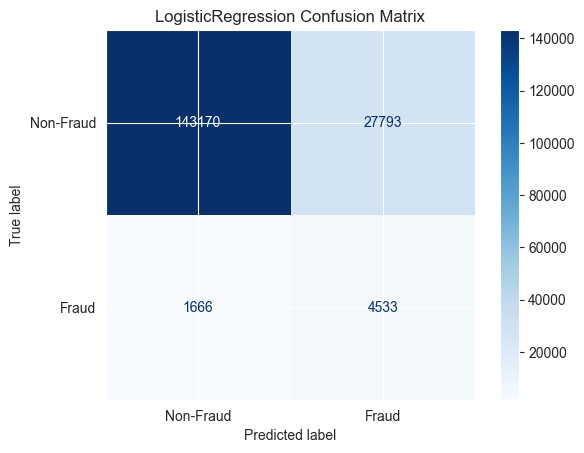

--- RandomForest ---
              precision    recall  f1-score   support

   Non-Fraud       0.98      1.00      0.99    170963
       Fraud       0.94      0.40      0.56      6199

    accuracy                           0.98    177162
   macro avg       0.96      0.70      0.77    177162
weighted avg       0.98      0.98      0.97    177162



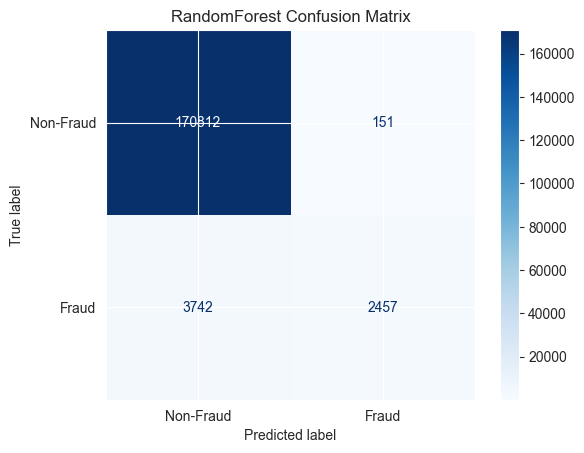

In [14]:
## 2.5 Classification Report & Confusion Matrix / 分类报告与混淆矩阵

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in baselines.items():
    preds = model.predict(X_test)
    print(f"--- {name} ---")
    print(classification_report(y_test, preds, target_names=['Non-Fraud', 'Fraud']))
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Fraud', 'Fraud'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

## 2.6 ROC & PR Curves Visualization / ROC 与 PR 曲线可视化

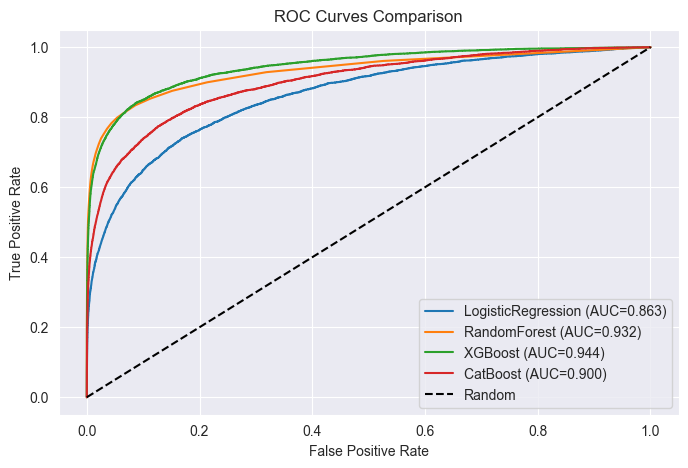

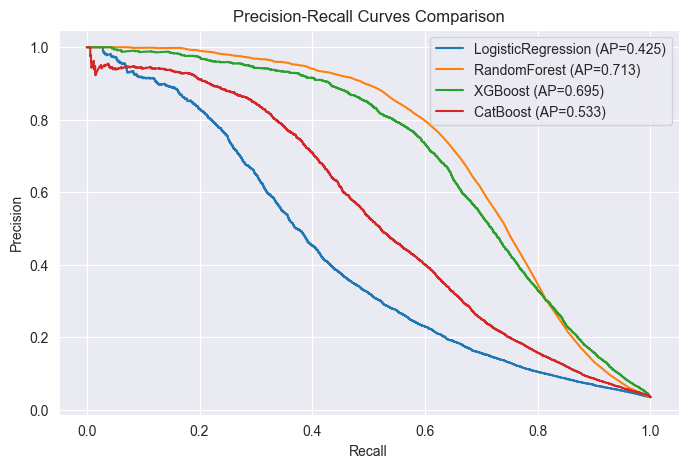

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# Collect model prediction scores for comparison
model_scores = {
    'LogisticRegression': baselines['LogisticRegression'].predict_proba(X_test)[:,1],
    'RandomForest':       baselines['RandomForest'].predict_proba(X_test)[:,1],
    'XGBoost':            xgb_clf.predict_proba(X_test)[:,1],
    'CatBoost':           cat_clf.predict_proba(X_test)[:,1]
}

# Plot ROC curves
plt.figure(figsize=(8,5))
for name, scores in model_scores.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_val = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(8,5))
for name, scores in model_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
plt.title('Precision-Recall Curves Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

## 2.7 Save Models & Preprocessor / 保存模型与预处理器
- Persist trained scalers, encoders, and best model for Part 3 deployment.
- Use joblib.dump for later loading.

In [16]:
import joblib

# Save numeric imputer & scaler
joblib.dump(num_imp, 'num_imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')
if cat_cols:
    joblib.dump(cat_enc, 'cat_encoder.pkl')

# Save best model (e.g. XGBoost)
joblib.dump(xgb_clf, 'fraud_xgb_model.pkl')

print("Artifacts saved: imputer, scaler, (encoder), and XGBoost model.")

Artifacts saved: imputer, scaler, (encoder), and XGBoost model.
